In [2]:
# basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from tqdm import tqdm_notebook as tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['figure.figsize'] = [10, 5]
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# required imports
import pickle
import xgboost
import catboost
import lightgbm
import sklearn

# feature eng
# import smogn
import regex
from sklearn.feature_selection import VarianceThreshold,SelectFromModel,RFE,RFECV
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,RepeatedStratifiedKFold,StratifiedShuffleSplit,KFold,LeaveOneOut,\
LeavePOut,GroupKFold,RandomizedSearchCV,GridSearchCV,ShuffleSplit,cross_validate,validation_curve,RepeatedKFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,MaxAbsScaler,QuantileTransformer,PowerTransformer
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# regression-all
from sklearn.linear_model import LinearRegression,Ridge,Lasso,BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.linear_model import Ridge,Lasso
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_log_error,make_scorer,mean_absolute_error,r2_score

C:\Users\Nimish\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nimish\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Nimish\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
SEED = 0
np.random.seed(SEED)

In [4]:
def rmsle(y, y_pred, **kwargs):
    out = np.sqrt(mean_squared_log_error(np.expm1(y), np.expm1(y_pred)))
    return out
                  
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [5]:
def data_encoder(ip_df,nom_list,ord_list,ohe_list,target_list):
    try:
        print("Inside Target Encoding")
        #Target Encoding for categorical features with high cardinality
        if len(target_list):
            te = TargetEncoder(cols = target_list)
            for col in target_list:
                ip_df[col] = te.fit_transform(ip_df[col], ip_df['Price'])
        
        print("Inside Label Encoding")
        #Label Encoding for nominal features
        if len(nom_list):
            le=LabelEncoder()
            for col in nom_list:
                ip_df[col]= le.fit_transform(ip_df[col])
            
        print("Inside Ordinal Encoding")
        # Ordinal Encoding for ordinal features
        if len(ord_list):
            oe = OrdinalEncoder()
            ip_df[ord_list]= oe.fit_transform(ip_df[ord_list])
                
        print("Inside OneHot Encoding")    
        # One Hot Encoding
        if len(ohe_list):
            ip_df = pd.get_dummies(ip_df, columns=ohe_list,drop_first=True)
#             ohe = OneHotEncoder(sparse=False)
#             ip_df[ohe_list]= ohe.fit_transform(ip_df[ohe_list])
        
        print(ip_df.shape)
        return ip_df
    except Exception as e:
        print(e)

In [6]:
def data_scaler(df_ip):
    try:
        scaled_df = pd.DataFrame(
                                 MinMaxScaler()  \
                                .fit_transform(df_ip),
                                columns=df_ip.columns
                                )
        print(scaled_df.shape)
        return scaled_df
    except Exception as e:
        print(e)

### Importing data

In [7]:
## Load the xlsx file available in the working or specified directory
#os.chdir('C:\\GL Class\DSBA - Python\Predictive Modeling\Week 1')
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [8]:
df_train.shape

(19237, 18)

In [9]:
df_test.shape

(8245, 18)

In [10]:
df_test = df_test.drop(['Price'], axis=1)

### Checking for Duplicates

In [11]:
# Are there any duplicates ?
train_dups = df_train.duplicated()
print('Number of duplicate rows in train set = %d' % (train_dups.sum()))
df_train[train_dups]
#test_dups = df_test.duplicated()
#print('Number of duplicate rows in test set = %d' % (test_dups.sum()))
#df_test[test_dups]

Number of duplicate rows in train set = 313


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
425,45815372,7840,-,MERCEDES-BENZ,E 200,1998,Sedan,No,CNG,2,180003 km,4.0,Manual,Rear,04-May,Left wheel,Black,4
1581,45815363,8781,-,TOYOTA,Ist,2002,Hatchback,No,Petrol,1.5,117000 km,4.0,Automatic,4x4,04-May,Right-hand drive,Red,4
1697,45732125,18503,-,TOYOTA,Prius,2010,Sedan,No,Petrol,1.8,162000 km,4.0,Automatic,Front,04-May,Left wheel,Grey,12
1972,45507765,20385,-,MERCEDES-BENZ,CLS 500,2005,Sedan,Yes,Petrol,5,230000 km,8.0,Tiptronic,Rear,04-May,Left wheel,Silver,10
2131,45815363,8781,-,TOYOTA,Ist,2002,Hatchback,No,Petrol,1.5,117000 km,4.0,Automatic,4x4,04-May,Right-hand drive,Red,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18974,45815465,2352,1273,LEXUS,IS 350,2015,Sedan,Yes,Petrol,3.5,80856 km,6.0,Automatic,4x4,04-May,Left wheel,Black,12
19137,45810466,15125,642,CHEVROLET,Orlando,2012,Jeep,Yes,Diesel,2,156834 km,4.0,Automatic,Front,04-May,Left wheel,Golden,4
19200,45725908,36065,640,MERCEDES-BENZ,CLA 250 AMG,2013,Sedan,Yes,Petrol,2.0 Turbo,68000 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,12
19203,45761487,13485,645,TOYOTA,Prius,2011,Sedan,No,Hybrid,1.8,281600 km,6.0,Automatic,Front,04-May,Left wheel,Grey,8


In [12]:
df_train.drop_duplicates(keep = 'first', inplace = True)
#df_test.drop_duplicates(keep = 'first', inplace = True)

In [13]:
# Are there any duplicates ?
train_dups = df_train.duplicated()
print('Number of duplicate rows in train set = %d' % (train_dups.sum()))
df_train[train_dups]
#test_dups = df_test.duplicated()
#print('Number of duplicate rows in test set = %d' % (test_dups.sum()))
#df_test[test_dups]

Number of duplicate rows in train set = 0


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags


In [14]:
df_train.shape

(18924, 18)

In [15]:
df_test.shape

(8245, 17)

drop the id column as it is useless for the model

In [16]:
df = pd.concat([df_train, df_test], axis=0)

In [17]:
#df.columns = churn.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('%', 'perc').str.replace('/','_by_').str.replace('&','and').str.replace('[', '_').str.replace(']', '').str.replace('-', '_').str.replace('.', '')
df.columns = df.columns.str.strip().str.replace('.', '').str.replace(' ','_')

In [18]:
df["Prod_year"]= pd.to_datetime(df["Prod_year"],format='%Y')

### Basic EDA

In [19]:
def basic_eda(df):
    print('SHAPE')
    print(df.shape)
    print('.' * 100)
    print('\nINFO')
    print(df.info())
    print('.' * 100)
    print('\nMISSING VALUES')
    print('Total Missing:', df.isna().sum().sum())
    print(df.isna().sum().sort_values(ascending = False))
    print('.' * 100)
    print('\nDUPLICATES')
    print(df.duplicated().sum())
    print('.' * 100)  
    print('\nDESCRIBE')
    print(df.describe())
    

In [20]:
basic_eda(df)

SHAPE
(27169, 18)
....................................................................................................

INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27169 entries, 0 to 8244
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID                27169 non-null  int64         
 1   Price             18924 non-null  float64       
 2   Levy              27169 non-null  object        
 3   Manufacturer      27169 non-null  object        
 4   Model             27169 non-null  object        
 5   Prod_year         27169 non-null  datetime64[ns]
 6   Category          27169 non-null  object        
 7   Leather_interior  27169 non-null  object        
 8   Fuel_type         27169 non-null  object        
 9   Engine_volume     27169 non-null  object        
 10  Mileage           27169 non-null  object        
 11  Cylinders         27169 non-null  float64       
 12  Gear_b


#### Dropping "id" as it different for every row and will be a noise for while building models

In [21]:
df.ID.nunique()

26886

In [22]:
df.head(2)

,ID,Price,Levy,Manufacturer,Model,Prod_year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags
0,45654403,13328.0,1399,LEXUS,RX 450,2010-01-01,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621.0,1018,CHEVROLET,Equinox,2011-01-01,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8


In [23]:
df = df.drop(['ID'], axis=1)

In [24]:
df.head(2)

,Price,Levy,Manufacturer,Model,Prod_year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags
0,13328.0,1399,LEXUS,RX 450,2010-01-01,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,16621.0,1018,CHEVROLET,Equinox,2011-01-01,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8


#### Copy

In [25]:
cars = df.copy()

#### Analysis

In [26]:
cars.shape

(27169, 17)

In [27]:
cars.head(2)

,Price,Levy,Manufacturer,Model,Prod_year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags
0,13328.0,1399,LEXUS,RX 450,2010-01-01,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,16621.0,1018,CHEVROLET,Equinox,2011-01-01,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8


#### Data Cleaning

In [28]:
cars['Levy'].replace(to_replace=['-'], value=0, inplace=True)

In [29]:
cars['Mileage'] = cars['Mileage'].str.strip().str.replace('km', '')

In [30]:
cars['Mileage'].replace(to_replace=['0 '], value=np.nan, inplace=True)

In [31]:
cars['Doors'] = cars['Doors'].str.strip().str.replace('04-May', '4')
cars['Doors'] = cars['Doors'].str.strip().str.replace('02-Mar', '2')

In [32]:
cars['Model'] = cars['Model'].str.strip().str.replace('09-03-2021', 'SAAB Model')

### Changing the data types of the features 

In [33]:
cars['Levy'] = cars['Levy'].astype(float)
cars['Mileage'] = cars['Mileage'].astype(float)
cars['Engine_volume']=cars['Engine_volume'].astype(str)

### Feature Engineering

In [34]:
def english_words_keeper(model_data):
    md_ = regex.sub('[^a-zA-Z0-9]',' ',model_data)
    return md_

cars['Model'] = cars['Model'].apply(english_words_keeper,1)
cars['Manufacturer'] = cars['Manufacturer'].apply(english_words_keeper,1)

In [35]:
# Extracts only numeric value for column Engine volume

cars[["Engine_volume", "Turbo"]] = cars["Engine_volume"].str.split(expand=True)
cars["Engine_volume"] = cars["Engine_volume"].astype("float")

# Keeps the information whether the engine is Turbo charged or not

cars["Turbo"].fillna("no", inplace=True)
cars["Turbo"].replace("Turbo", "yes", inplace=True)

In [36]:
#creating Engine type column
#cars['Engine_Type']=['Non-turbo' if len(i)==1 else 'Turbo' for i in cars['Engine_volume'].str.split()]

#### Feature Engineering

In [37]:
cars['Leather_interior'] = cars['Leather_interior'].map({'Yes':1,'No':0})
cars['Turbo'] = cars['Turbo'].map({'yes':1,'no':0})

In [38]:
cars['Levy'] = cars['Levy'].replace('-',np.nan).astype(float) # check
cars['Levy'] = cars['Levy'].fillna(cars['Levy'].median())

In [39]:
cars['Car_Age'] = 2021 - cars['Prod_year'].dt.year

In [40]:
cars['Car_Age']

0       11
1       10
2       15
3       10
4        7
        ..
8240    17
8241     9
8242     6
8243     4
8244     9
Name: Car_Age, Length: 27169, dtype: int64

In [41]:
#dropping production collumn
cars=cars.drop(['Prod_year'],axis=1)

### Imputation

In [42]:
cars.isna().sum()

Price               8245
Levy                   0
Manufacturer           0
Model                  0
Category               0
Leather_interior       0
Fuel_type              0
Engine_volume          0
Mileage             1006
Cylinders              0
Gear_box_type          0
Drive_wheels           0
Doors                  0
Wheel                  0
Color                  0
Airbags                0
Turbo                  0
Car_Age                0
dtype: int64

In [43]:
cars['Mileage'].fillna(value = cars['Mileage'].median(), inplace = True)

In [44]:
cars.isna().sum()

Price               8245
Levy                   0
Manufacturer           0
Model                  0
Category               0
Leather_interior       0
Fuel_type              0
Engine_volume          0
Mileage                0
Cylinders              0
Gear_box_type          0
Drive_wheels           0
Doors                  0
Wheel                  0
Color                  0
Airbags                0
Turbo                  0
Car_Age                0
dtype: int64

### Seperating out numerical and categorical features

In [45]:
df_num = cars.select_dtypes(include = 'number')
df_cat = cars.select_dtypes(exclude = 'number')

In [46]:
df_num.head(2)

,Price,Levy,Leather_interior,Engine_volume,Mileage,Cylinders,Airbags,Turbo,Car_Age
0,13328.0,1399.0,1,3.5,186005.0,6.0,12,0,11
1,16621.0,1018.0,0,3.0,192000.0,6.0,8,0,10


In [47]:
df_cat.head(2)

,Manufacturer,Model,Category,Fuel_type,Gear_box_type,Drive_wheels,Doors,Wheel,Color
0,LEXUS,RX 450,Jeep,Hybrid,Automatic,4x4,4,Left wheel,Silver
1,CHEVROLET,Equinox,Jeep,Petrol,Tiptronic,4x4,4,Left wheel,Black


#### Numerical Corr

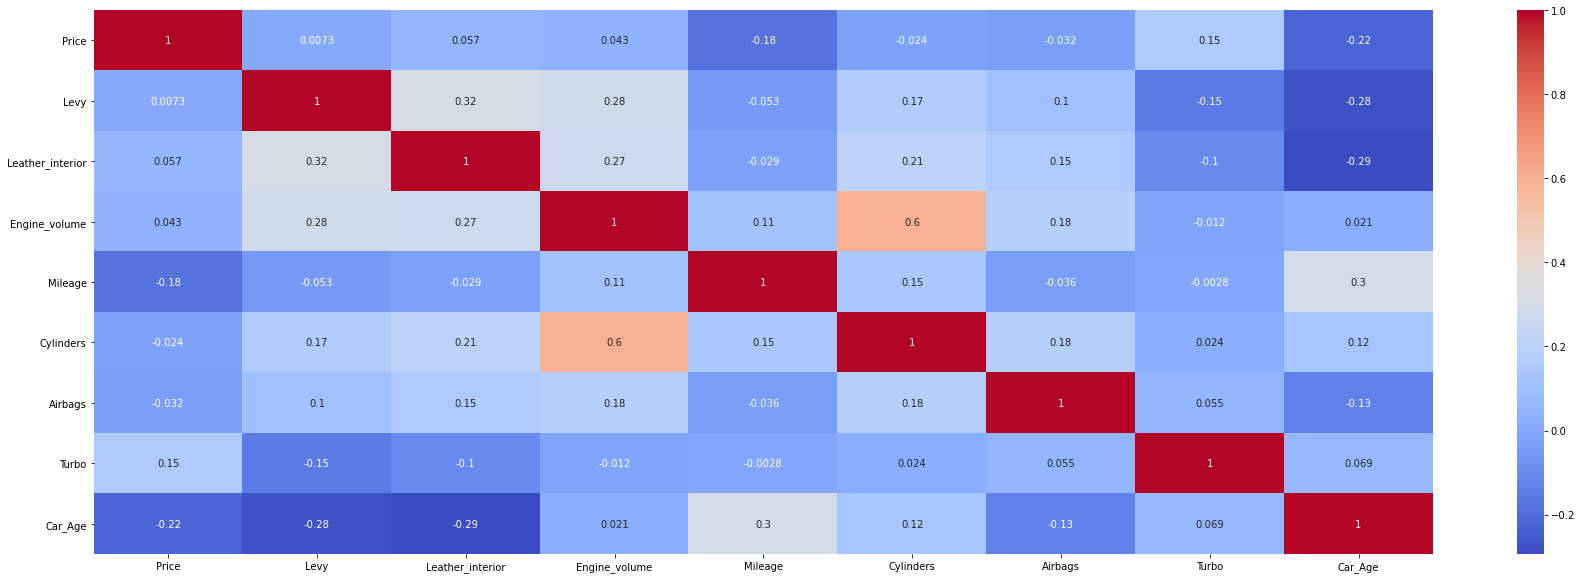

In [48]:
plt.figure(figsize = (30,10))
sns.heatmap(cars.corr(method='kendall'),cmap='coolwarm',annot=True);

#### Chi-2 Corr

In [49]:
df_cat = cars.select_dtypes(include='object')

In [50]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return np.sqrt((stat/(obs*mini)))

In [51]:
rows= []

for var1 in df_cat:
    col = []
    for var2 in df_cat :
        cramers = cramers_V(df_cat[var1], df_cat[var2]) # Cramer's V test
        col.append(cramers) 
    rows.append(col)

cramers_results = np.array(rows)
    
df_categorical_corr_vars = pd.DataFrame(cramers_results, columns = df_cat.columns, index =df_cat.columns)

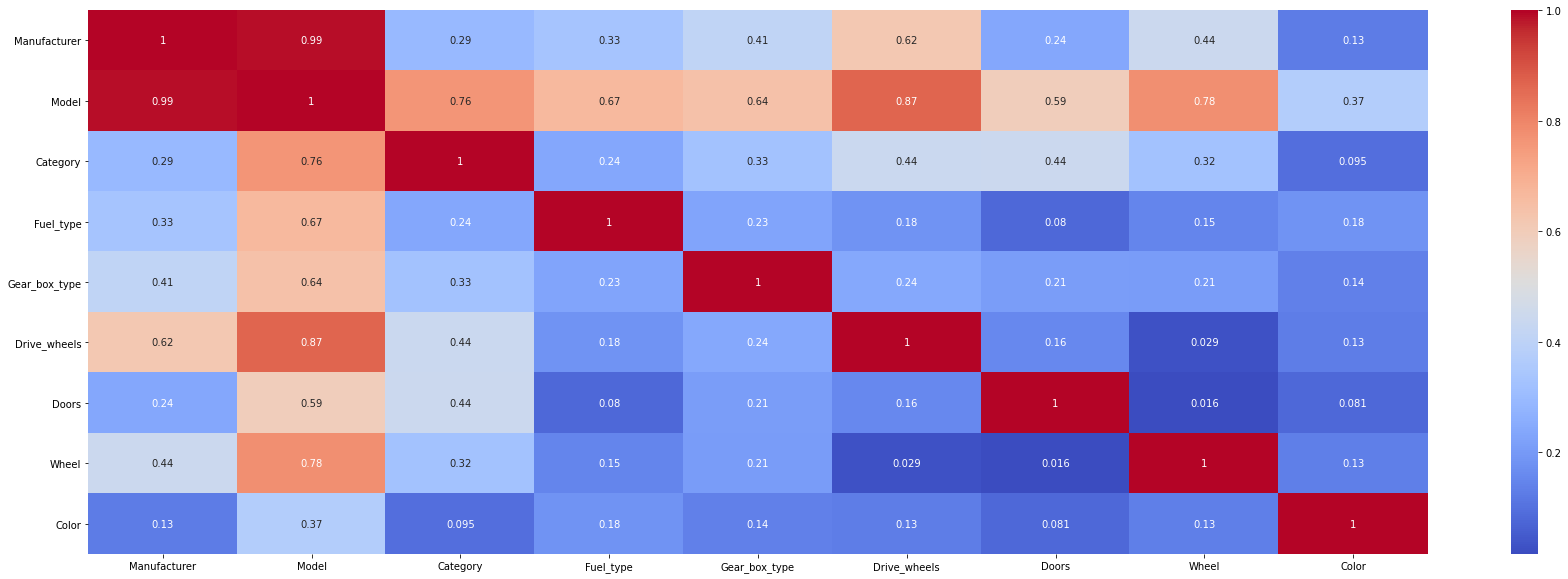

In [52]:
plt.figure(figsize = (30,10))
sns.heatmap(df_categorical_corr_vars,annot=True,cmap='coolwarm');

#### Feature selection on the basis pf Corr and Chi-2 results

In [53]:
# #fe_remove_cols = ['Current_Year','Prod_year','Model'] # 'Cylinders' can be droppped but lets check 
# #cars = cars.drop(columns=fe_remove_cols)

# #selecting features other than 'Current_Year','Prod_year','Model'
# cars = cars[['Price', 'Levy', 'Leather_interior', 'Engine_volume', 'Mileage',
#        'Cylinders', 'Airbags', 'Turbo', 'Car_Age','Manufacturer', 'Model', 'Category', 'Fuel_type', 'Gear_box_type',
#        'Drive_wheels', 'Wheel', 'Color']]

**Check for Outliers**

Shape before Outliers Treatment (27169, 18)


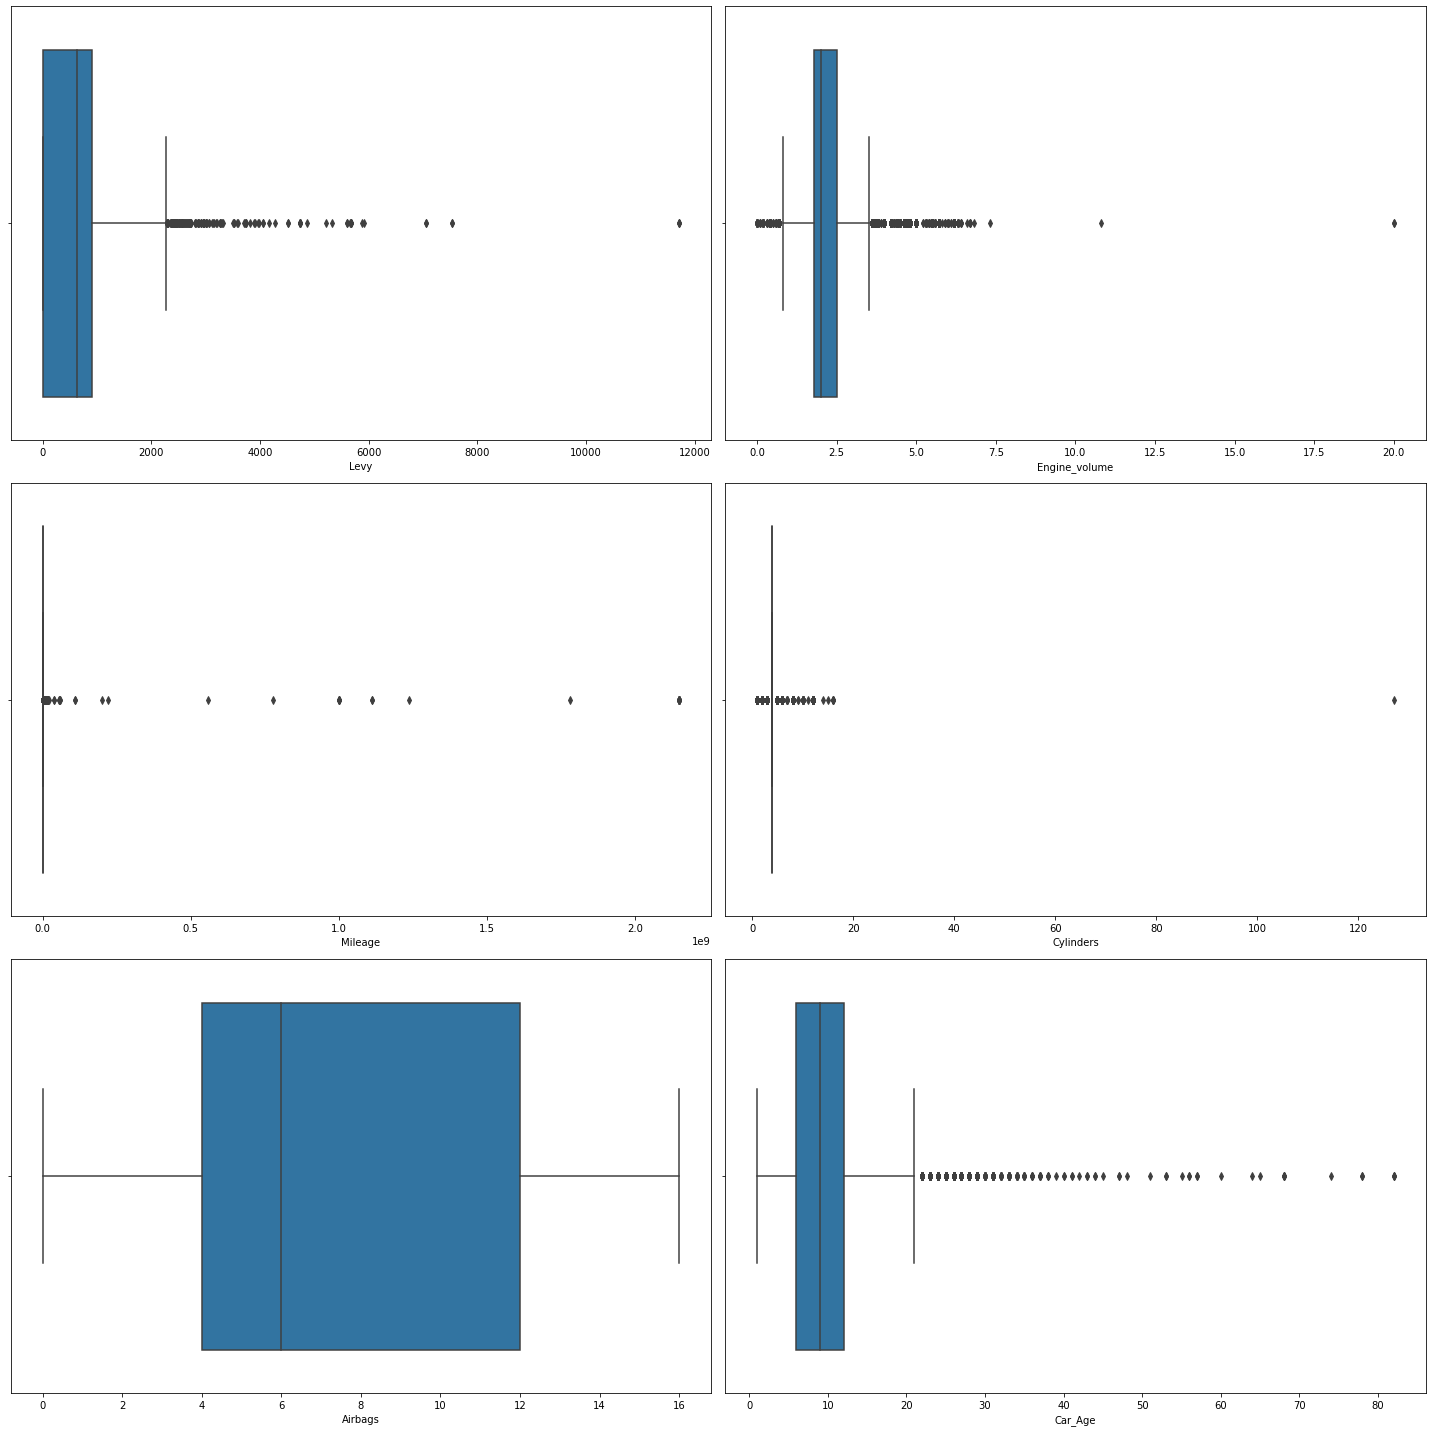

In [54]:
data_plot=cars[['Levy', 'Engine_volume', 'Mileage','Cylinders', 'Airbags', 'Car_Age']]
fig=plt.figure(figsize=(20,20))
for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(3,2,i+1)
    sns.boxplot(data_plot[data_plot.columns[i]])
    plt.tight_layout()
print('Shape before Outliers Treatment',cars.shape)

**Outliers Treatment**

In [55]:
Q1 = cars.quantile(0.25) # Getting First quantile for all numerical variables
Q3 = cars.quantile(0.75) # Getting Second quantile for all numerical variables
IQR = Q3 - Q1          # Getting IQR values
lower_range= Q1-(1.5 * IQR) #Getting Lower Limit for all numerical variables
upper_range= Q3+(1.5 * IQR) #Getting Upper Limit for all numerical variables

In [56]:
lower_range

Price              -19767.00
Levy                -1375.50
Leather_interior       -1.50
Engine_volume           0.75
Mileage            -85000.00
Cylinders               4.00
Airbags                -8.00
Turbo                   0.00
Car_Age                -3.00
dtype: float64

In [57]:
upper_range

Price                47161.00
Levy                  2292.50
Leather_interior         2.50
Engine_volume            3.55
Mileage             355000.00
Cylinders                4.00
Airbags                 24.00
Turbo                    0.00
Car_Age                 21.00
dtype: float64

In [58]:
cars['Levy']=np.where(cars['Levy']> 2292.50,2292.50,cars['Levy'])

cars['Engine_volume']=np.where(cars['Engine_volume']< 0.75,0.75,cars['Engine_volume'])
cars['Engine_volume']=np.where(cars['Engine_volume']> 3.55,3.55,cars['Engine_volume'])

cars['Car_Age']=np.where(cars['Car_Age']> 21,21,cars['Car_Age'])

Shape After Outliers Treatment (27169, 18)


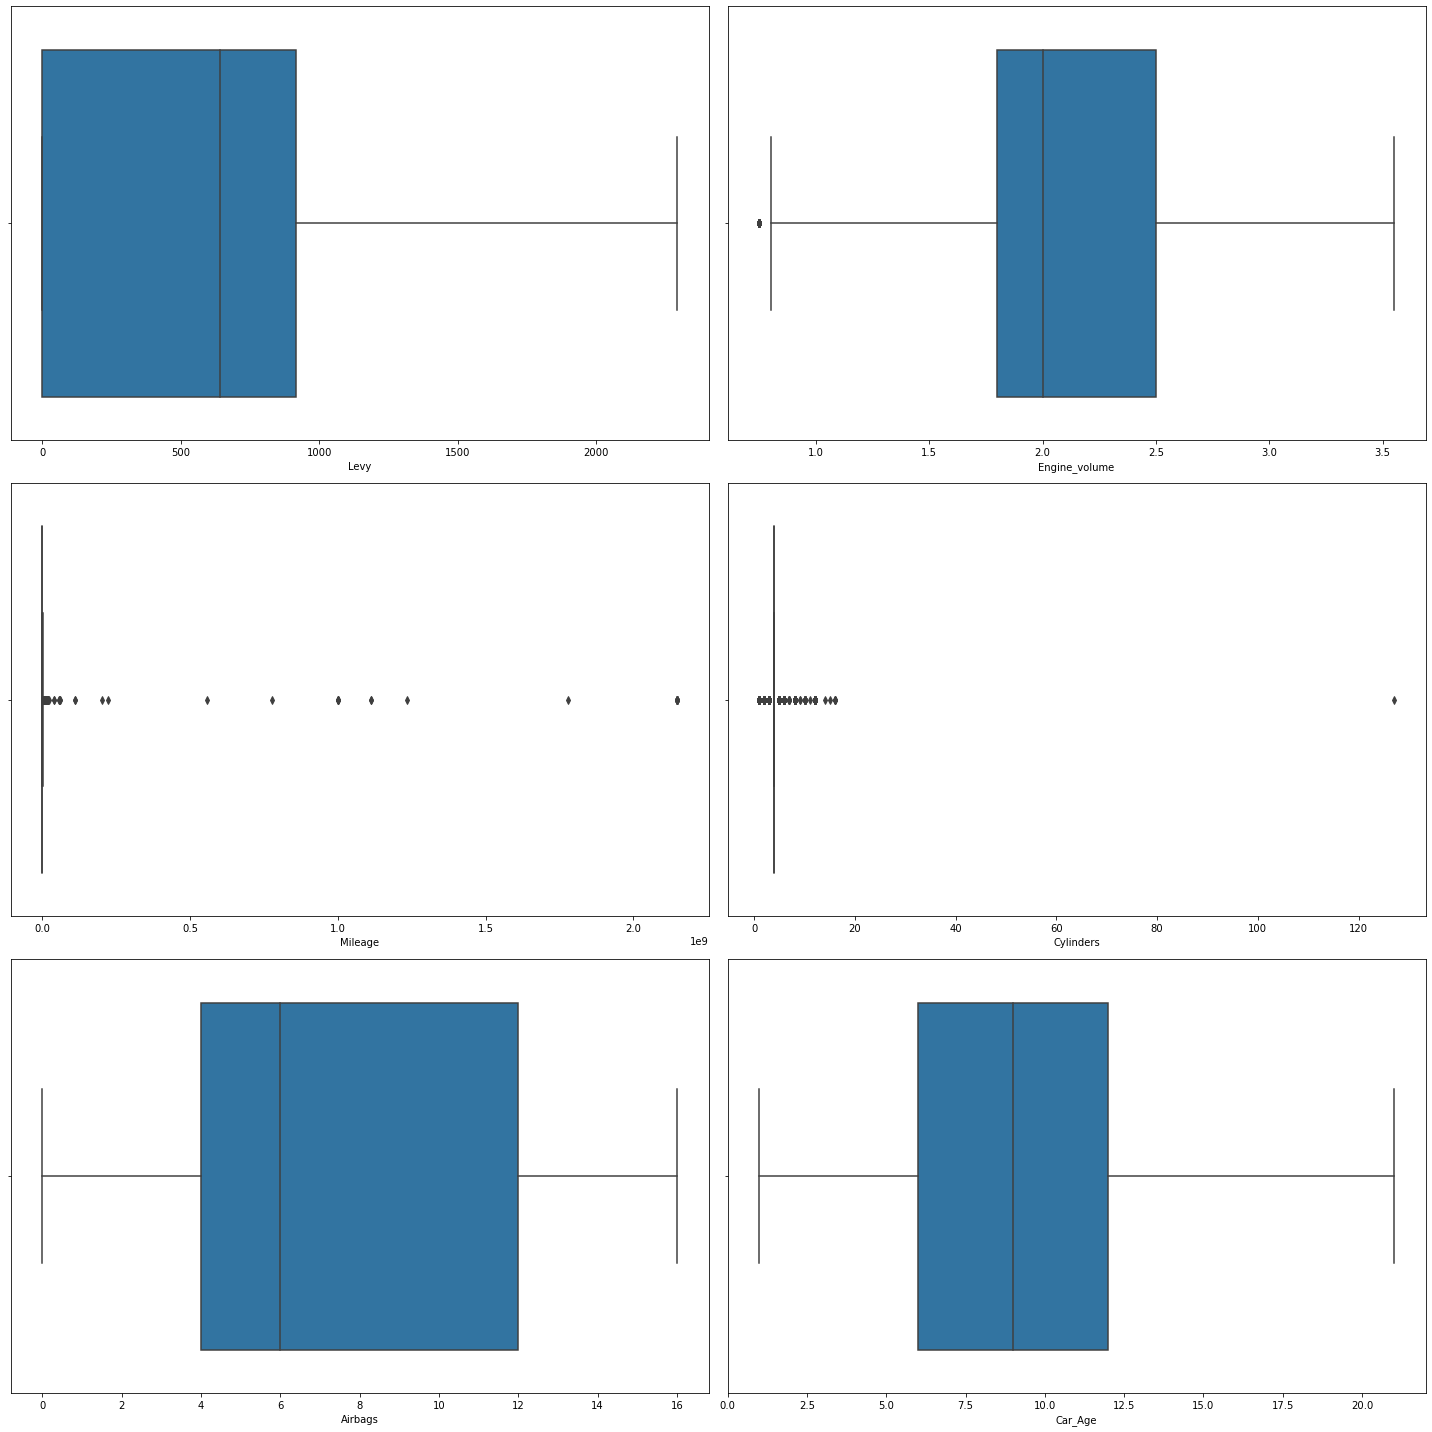

In [59]:
data_plot=cars[['Levy', 'Engine_volume', 'Mileage','Cylinders', 'Airbags', 'Car_Age']]
fig=plt.figure(figsize=(20,20))
for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(3,2,i+1)
    sns.boxplot(data_plot[data_plot.columns[i]])
    plt.tight_layout()

print('Shape After Outliers Treatment',cars.shape)

### Seperating Train and Test sets to the original values

In [60]:
df_train = cars[0:18924]

In [61]:
df_test = cars[18924:]

In [62]:
df_test = df_test.drop(['Price'], axis =1)

In [63]:
df_test.shape

(8245, 17)

### BaseLine Approach

#### Independent | Dependent Vars

In [64]:
input_df = df_train.drop(columns=['Price'])
target = np.log(df_train['Price'])

In [65]:
input_df.head(2)

,Levy,Manufacturer,Model,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Turbo,Car_Age
0,1399.0,LEXUS,RX 450,Jeep,1,Hybrid,3.5,186005.0,6.0,Automatic,4x4,4,Left wheel,Silver,12,0,11
1,1018.0,CHEVROLET,Equinox,Jeep,0,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,4,Left wheel,Black,8,0,10


In [66]:
input_df.columns

Index(['Levy', 'Manufacturer', 'Model', 'Category', 'Leather_interior',
       'Fuel_type', 'Engine_volume', 'Mileage', 'Cylinders', 'Gear_box_type',
       'Drive_wheels', 'Doors', 'Wheel', 'Color', 'Airbags', 'Turbo',
       'Car_Age'],
      dtype='object')

In [67]:
#def data_encoder(ip_df,nom_list,ord_list,ohe_list,target_list):
nom_list = ['Model','Manufacturer','Category','Fuel_type', 'Gear_box_type','Wheel', 'Color','Drive_wheels']
ord_list = ['Doors']
ohe_list = []
target_list = []
input_df_encoded_scaled = data_scaler(data_encoder(input_df,nom_list,ord_list,ohe_list,target_list))

Inside Target Encoding
Inside Label Encoding
Inside Ordinal Encoding
Inside OneHot Encoding
(18924, 17)
(18924, 17)


In [68]:
input_df_encoded_scaled.head(1)

,Levy,Manufacturer,Model,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Turbo,Car_Age
0,0.610251,0.515625,0.781348,0.4,1.0,0.333333,0.982143,0.000087,0.333333,0.0,0.0,0.5,0.0,0.8,0.75,0.0,0.5


### Model Building

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

#### Preparing the baseline models

In [70]:
# prepare models
models = []
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ENet', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('XGB', xgb.XGBRegressor()))

In [71]:
input_df_encoded_scaled.shape

(18924, 17)

In [72]:
target.shape

(18924,)

In [73]:
# evaluate each model in turn
results = []
names = []
seed = 42
scoring = rmsle_scorer
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, input_df_encoded_scaled, target, cv=kfold, scoring=scoring,verbose=1)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LR: -1.470064 (0.027130)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ridge: -1.470020 (0.027136)
Lasso: -1.588669 (0.032217)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ENet: -1.588669 (0.032217)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNN: -1.076618 (0.033071)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CART: -1.324639 (0.049594)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RF: -0.961779 (0.026498)
XGB: -0.992305 (0.020782)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.0s finished


In [74]:
input_df_encoded_scaled.shape

(18924, 17)

In [75]:
estimator = RandomForestRegressor()
param_grid = { 
            "n_estimators"      : [300,500],
            "max_features"      : [5,10,17],
            'max_depth': [10,15],
            "min_samples_split" : [10,20]
}

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=10,scoring = rmsle_scorer,verbose=1)

grid.fit(input_df_encoded_scaled, target)
print(grid.best_score_)
print(grid.best_params_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 14.5min finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 15], 'max_features': [5, 10, 17],
                         'min_samples_split': [10, 20],
                         'n_estimators': [300, 500]},
             scoring=make_scorer(rmsle, greater_is_better=False), verbose=1)

-0.9647897782753689
{'max_depth': 15, 'max_features': 10, 'min_samples_split': 10, 'n_estimators': 500}


In [76]:
rf_model = RandomForestRegressor(max_depth = 25, max_features = 10, min_samples_split = 5, n_estimators = 200)

rf_cv = cross_val_score(rf_model,
                             input_df_encoded_scaled, target, groups = None, scoring = rmsle_scorer, 
                             cv = 10, n_jobs = -1, verbose = 1)
rf_cv.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   18.2s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   26.5s finished


-0.9338434048064179

In [77]:
rf_model.fit(input_df_encoded_scaled, target)

RandomForestRegressor(max_depth=25, max_features=10, min_samples_split=5,
                      n_estimators=200)

In [79]:
pd.DataFrame(rf_model.feature_importances_, index = input_df_encoded_scaled.columns, columns = ['Feature Importance']).sort_values(ascending = False, by = ['Feature Importance'])

,Feature Importance
Airbags,0.175228
Mileage,0.167275
Car_Age,0.115568
Levy,0.094705
Gear_box_type,0.093801
Engine_volume,0.055635
Model,0.053799
Manufacturer,0.046426
Color,0.044486
Fuel_type,0.033300


#### Predictions  on the test data

In [80]:
df_test = data_scaler(data_encoder(df_test,nom_list,ord_list,ohe_list,target_list))

Inside Target Encoding
Inside Label Encoding
Inside Ordinal Encoding
Inside OneHot Encoding
(8245, 17)
(8245, 17)


In [81]:
rf_test_prediction = np.expm1(rf_model.predict(df_test))
rf_test_prediction

array([15700.49612018,  5431.26684999,  5519.85868928, ...,
        5247.51391987, 42333.56930538,   709.14986647])

#### Final Submission

In [ ]:
len(rf_test_prediction)

In [ ]:
rf_test_prediction

In [ ]:
solution_df = pd.DataFrame()
#solution_df['Price'] = pd.Series(dl_test_prediction.flatten())
solution_df['Price'] = rf_test_prediction
solution_df

In [ ]:
solution_df.to_csv('Submission_v6_1.csv',index=False)

### Using Exhaustive Feature Selection

In [ ]:
# from mlxtend.feature_selection import ExhaustiveFeatureSelector

In [ ]:
# efs = ExhaustiveFeatureSelector(RandomForestRegressor(),
#                                min_features=4,
#                                max_features=8,
#                                scoring=scoring,
#                                cv=5)

In [ ]:
# efs = efs.fit(input_df_encoded_scaled,target)

In [ ]:
# selected_features = X_train.columns(list(efs.best_idx_))
# print(selected_features)
# print(efs.best_score_)